# Implementing linear regression algorithm

## Quadratic linear regression

### Importing the libraries

In [7]:
## general
import io
## data
import pandas as pd
import numpy as np
## machine learning
import keras
## data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

### Utils Functions

In [11]:
#@title Define plotting functions

def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


## Define ML Functions

In [12]:
def build_model(my_learning_rate,num_features):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(units=1,input_shape=(num_features, )))
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),loss="mean_squared_error",metrics=[keras.metrics.RootMeanSquaredError()])
  return model

def train_model(model,df,features,label,epochs,batch_size):
  history = model.fit(x=features,y=label,batch_size=batch_size,epochs=epochs)
  trained_weights = model.get_weights()[0]
  trained_biases = model.get_weights()[1]
  epochs = history.Epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]
  return trained_weights,trained_biases,epochs,rmse

def run_experiment(df,feature_names,label_name,learning_rate,epochs,batch_size):
  print('INFO: starting training experiment with features={} and label={}\n'.format(feature_names, label_name))
  num_features = len(feature_names)
  features = df.loc[:,feature_names].values()
  label = df[label_name].values()


### Loading the data

In [2]:
chicago_taxi_dataset = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/chicago_taxi_train.csv")

### Initial Processing

In [8]:
training_df = chicago_taxi_dataset[['TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE']]

### Analyzing the data

In [6]:
## basic statistics
training_df.describe()

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
count,31694.000000,31694.000000,31694.000000,31694.000000
mean,8.289463,1319.796397,23.905210,12.965785
std,7.265672,928.932873,16.970022,15.517765
min,0.500000,60.000000,3.250000,0.000000
25%,1.720000,548.000000,9.000000,0.000000
50%,5.920000,1081.000000,18.750000,12.200000
75%,14.500000,1888.000000,38.750000,20.800000
max,68.120000,7140.000000,159.250000,648.600000


In [9]:
## correlation
training_df.corr(numeric_only=True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.000000,0.800855,0.975344,-0.049594
TRIP_SECONDS,0.800855,1.000000,0.830292,-0.084294
FARE,0.975344,0.830292,1.000000,-0.070979
TIP_RATE,-0.049594,-0.084294,-0.070979,1.000000


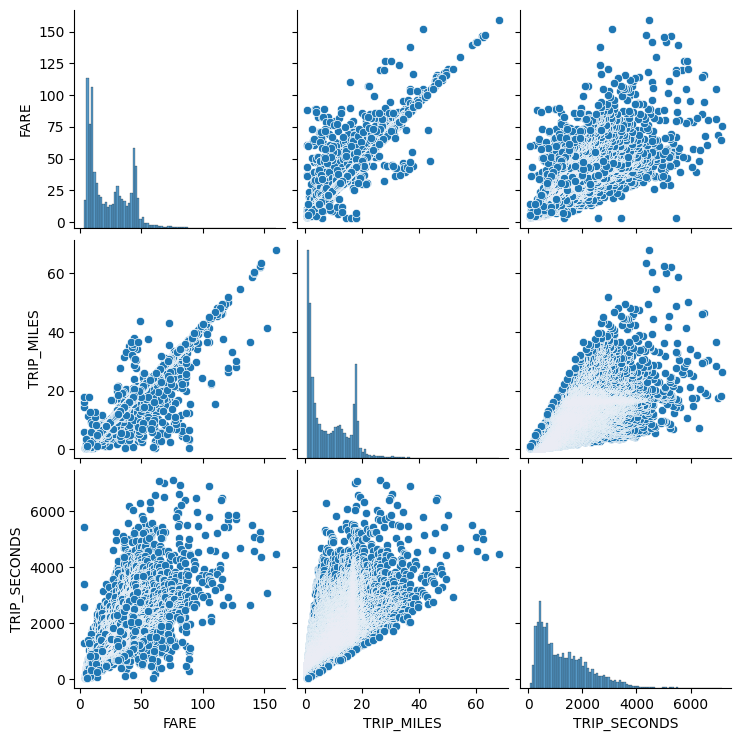

In [10]:
## pairplot
sns.pairplot(training_df, x_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"],y_vars=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

Plotting the data using matplotlib

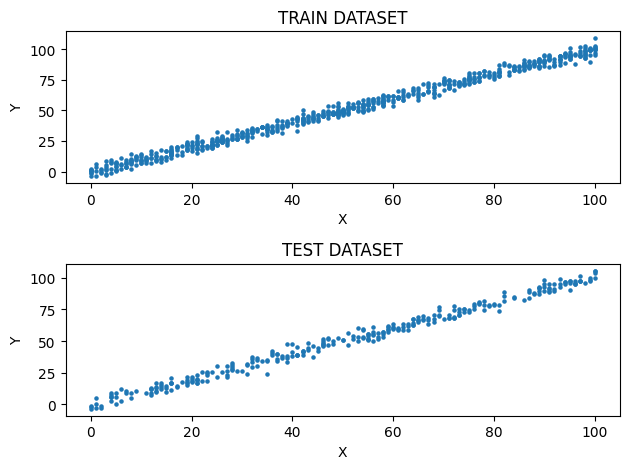

In [ ]:
figure,axis = plt.subplots(2,1)
trainX = trainData[::,0]
trainY = trainData[::,1]
axis[0].set_title("TRAIN DATASET")
axis[0].scatter(trainX,trainY,s = 5)
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
testX = testData[::,0]
testY = testData[::,1]
axis[1].set_title('TEST DATASET')
axis[1].scatter(testX,testY,s = 5)
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
figure.tight_layout()
plt.show()
trainX = trainX.reshape(-1,1)
testX = testX.reshape(-1,1)


Implementing linear regression using inbuilt function

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

clf = LinearRegression()
clf.fit(trainX,trainY)
y_pred = clf.predict(testX)
print(r2_score(testY,y_pred))

0.9888014444327563


### Implementing my own gradient descent

Batch Gradient Descent

In [ ]:
def batchGradientDescent(alpha,it,N):
    A = np.array([0,0]).reshape((1,2))
    X = np.concatenate((np.ones((N,1)),trainX),axis = 1)
    Y = trainY.reshape((N,1))
    Xt = np.transpose(X)
    Yt = np.transpose(Y)
    while (it > 0):
        A = A - (alpha/N)*(np.matmul(A,np.matmul(Xt,X))-np.matmul(Yt,X))
        Ypred = np.matmul(A,Xt)
        it = it - 1
    return A
thetaBatch = batchGradientDescent(0.0001,1000,699)

Incremental Gradient Descent

In [ ]:
def incrementalGradientDescent(alpha,it,N):
    theta = np.zeros((2,1))
    while it > 0:
        for i in range(N):
            y = trainY[i]
            y = np.reshape(y,(1,1))
            x = trainX[i,::]
            x = np.reshape(x,(1,1))
            C = y - np.matmul(theta,np.transpose(x))
            x = np.concatenate((np.ones((1,1)),x),axis = 0)
            theta = theta + (alpha/N)*C*x
            it = it - 1
            if it == 0: break
        if it == 0: break
    return np.transpose(theta)
thetaIncrement = incrementalGradientDescent(0.0001,100000,699)



Plotting the curve obtained by performing gradient descent above.

R2 Score of Batch Gradient Descent: 0.9887734053310671
R2 Score of Incremential Gradient Descent: 0.9888517297994651


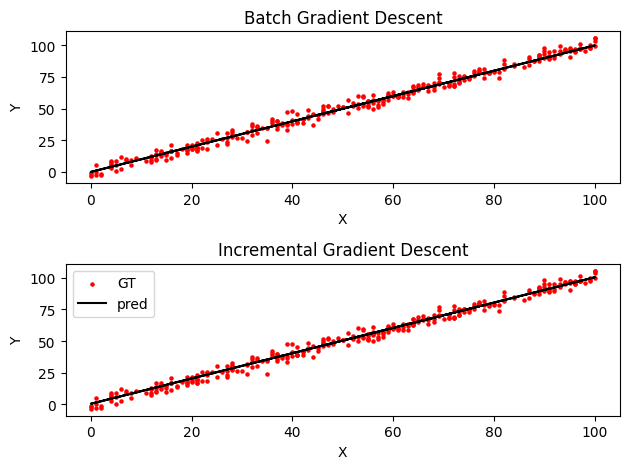

In [ ]:
X = np.concatenate((np.ones((300,1)),testX),axis = 1)
predYBatch = np.matmul(X,np.transpose(thetaBatch))
predYIncrement = np.matmul(X,np.transpose(thetaIncrement))
realY = testY.reshape(300,1)
print('R2 Score of Batch Gradient Descent:',r2_score(realY,predYBatch))
print('R2 Score of Incremential Gradient Descent:',r2_score(realY,predYIncrement))
figure,axis = plt.subplots(2,1)
axis[0].set_title('Batch Gradient Descent')
axis[0].scatter(testX,testY,color = 'red',s = 5,label = 'GT')
axis[0].plot(testX,predYBatch,color = 'black',label = 'pred')
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
axis[1].set_title('Incremental Gradient Descent')
axis[1].scatter(testX,testY,color = 'red',s = 5,label = 'GT')
axis[1].plot(testX,predYIncrement,color = 'black',label = 'pred')
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
figure.tight_layout()
plt.legend()
plt.show()